In [74]:
import matplotlib.pyplot as plt

def get_time(data):
    s = 0
    start_ms = data[0][0][1]  # Ensure we access the correct nested structure
    ms_prev = 1000

    for i in range(len(data)):
        if isinstance(data[i][0], list) and len(data[i][0]) > 1:  # Check structure
            ms = data[i][0][1] - start_ms
        else:
            raise TypeError(f"Unexpected structure in data[{i}][0]: {data[i][0]}")

        if ms < ms_prev:
            s += 1
        ms_prev = ms

    if ms < 0:
        s -= 1
        ms += 1000
    return s + ms / 1000.0

def plot(data):
    title = data[0]
    data = data[1:]

    # Extract Vicon and Debug data
    vicon_data = [entry[0][2:] for entry in data]  # Extract x, y, z, roll, pitch, yaw
    debug_data = [entry[1] for entry in data]     # Extract goal x, y, z

    # Time values for x-axis
    total_time = get_time(data)
    num_points = len(data)
    time_values = [i * (total_time / num_points) for i in range(num_points)]
    
    # Labels and titles
    column_labels = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']
    y_axis_labels = ['Position [m]', 'Position [m]', 'Position [m]', 'Angle [rad]', 'Angle [rad]', 'Angle [rad]']
    title_text = [' Position', ' Position', ' Position', ' Orientation', ' Orientation', ' Orientation']

    # Create 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, label in enumerate(column_labels):
        if i < 3:  # X, Y, Z
            # Plot Vicon data
            component_data = [entry[i] for entry in vicon_data]
            axes[i].plot(time_values, component_data, marker='o', linestyle='-', markersize=1, label=f'Vicon {label}')
            
            # Overlay Debug goal data
            goal_data = [entry[i] for entry in debug_data]
            axes[i].plot(time_values, goal_data, marker='x', linestyle='--', markersize=3, label=f'Goal {label}')
        else:  # Roll, Pitch, Yaw
            # Plot Vicon data only
            component_data = [entry[i] for entry in vicon_data]
            axes[i].plot(time_values, component_data, marker='o', linestyle='-', markersize=1, label=f'Vicon {label}')

        # Set titles, labels, and legends
        axes[i].set_title(label + title_text[i], fontsize=14)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(y_axis_labels[i])
        axes[i].legend()
        axes[i].grid(True)

    # Add global title
    fig.suptitle(f"{title}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def linreg_plot(data):
    from scipy.stats import linregress
    
    z = []
    num_points = len(data) - 1  # Exclude the title/header

    total_seconds = get_time(data[1:])

    # Generate time values in seconds for each sample
    times = [i * (total_seconds / (num_points-1)) for i in range(num_points)] if num_points > 1 else [0]

    for i in range(1, len(data)):
        current_z = data[i][0][4]
        z.append(current_z)

    slope, intercept, r_value, p_value, std_err = linregress(times, z)

    # Plot the data and the regression line
    plt.figure(figsize=(8, 5))
    plt.plot(times, z, 'o', label='Z data')
    plt.plot(times, [slope*t + intercept for t in times], 'r-', label='Linear fit')

    info_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\nR²: {r_value**2:.4f}"
    plt.gca().text(0.05, 0.05, info_text, transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='bottom', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

    plt.xlabel('Time [s]')
    plt.ylabel('Z')
    plt.title('Linear Regression of Z')
    plt.legend()
    plt.grid(True)
    plt.show()


In [75]:
mcap_path =  r"RosBags\TurnOffTest0805V3\TurnOffTest0805V3_0.mcap"
# ex. "RosBags/PIDTEST0805V4/PIDTEST0805V4_0.mcap"
# ex. r"RosBags\TurnOffTest0805\TurnOffTest0805_0.mcap"

In [76]:
from mcap_ros2.reader import read_ros2_messages
from pathlib import Path
import os

base_path = Path(os.getcwd()).parent
mcap_full_path = base_path / mcap_path

with open(mcap_full_path, "rb") as f:
    rosout_msgs = []
    change_pos = []
    
    current_group = None
    vicon = False
    debug = False
    quatantion = False
    
    i = 0
    for msg in read_ros2_messages(f):
        topic = msg.channel.topic
                
        if topic == "/rosout":
            if not rosout_msgs or msg.ros_msg.msg != (rosout_msgs[-1][0]):
                current_group = [msg.ros_msg.msg]
                rosout_msgs.append(current_group)
                
                if 'Starting goal position' in msg.ros_msg.msg:
                    change_pos.append(i)
                
                if 'Turning off the drone' in msg.ros_msg.msg:
                    change_pos.append(i)
                i += 1

        elif topic == "/Vicon" and current_group is not None:
            current_vicon = msg.ros_msg.data
            vicon = True

        elif topic == "/debug_variables":
            current_debug = [msg.ros_msg.goal_x, msg.ros_msg.goal_y, msg.ros_msg.goal_z]
            debug = True
        
        elif topic == "/fmu/in/vehicle_attitude_setpoint":
            current_quatantion = msg.ros_msg.q_d
            quatantion = True

        if vicon and debug and quatantion:
            current_group.append([current_vicon, current_debug, current_quatantion])
            vicon = False
            debug = False
            quatantion = False


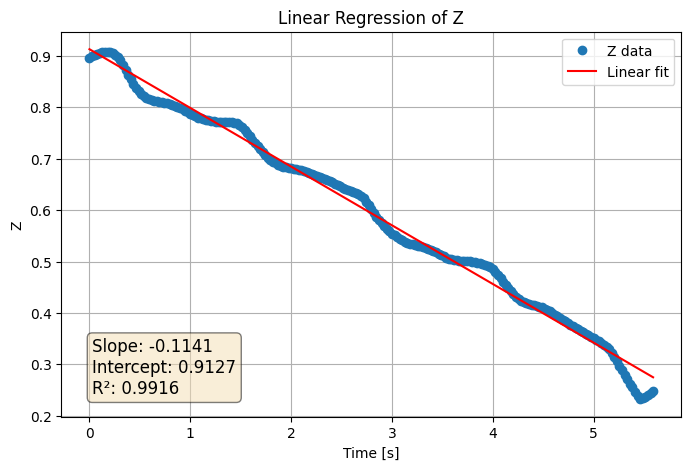

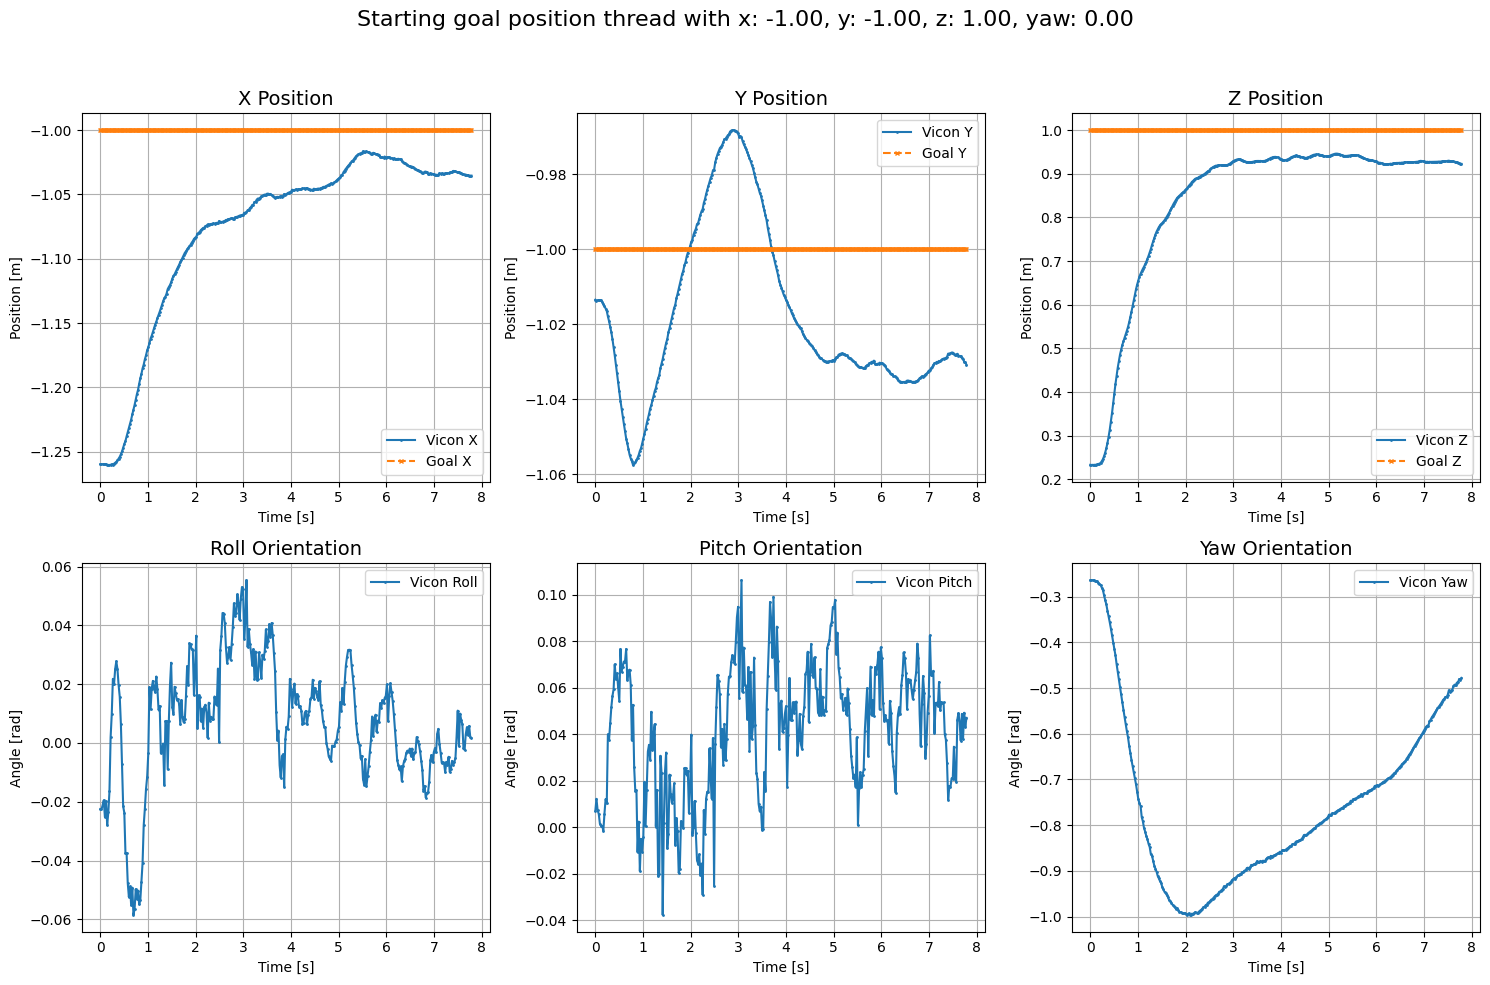

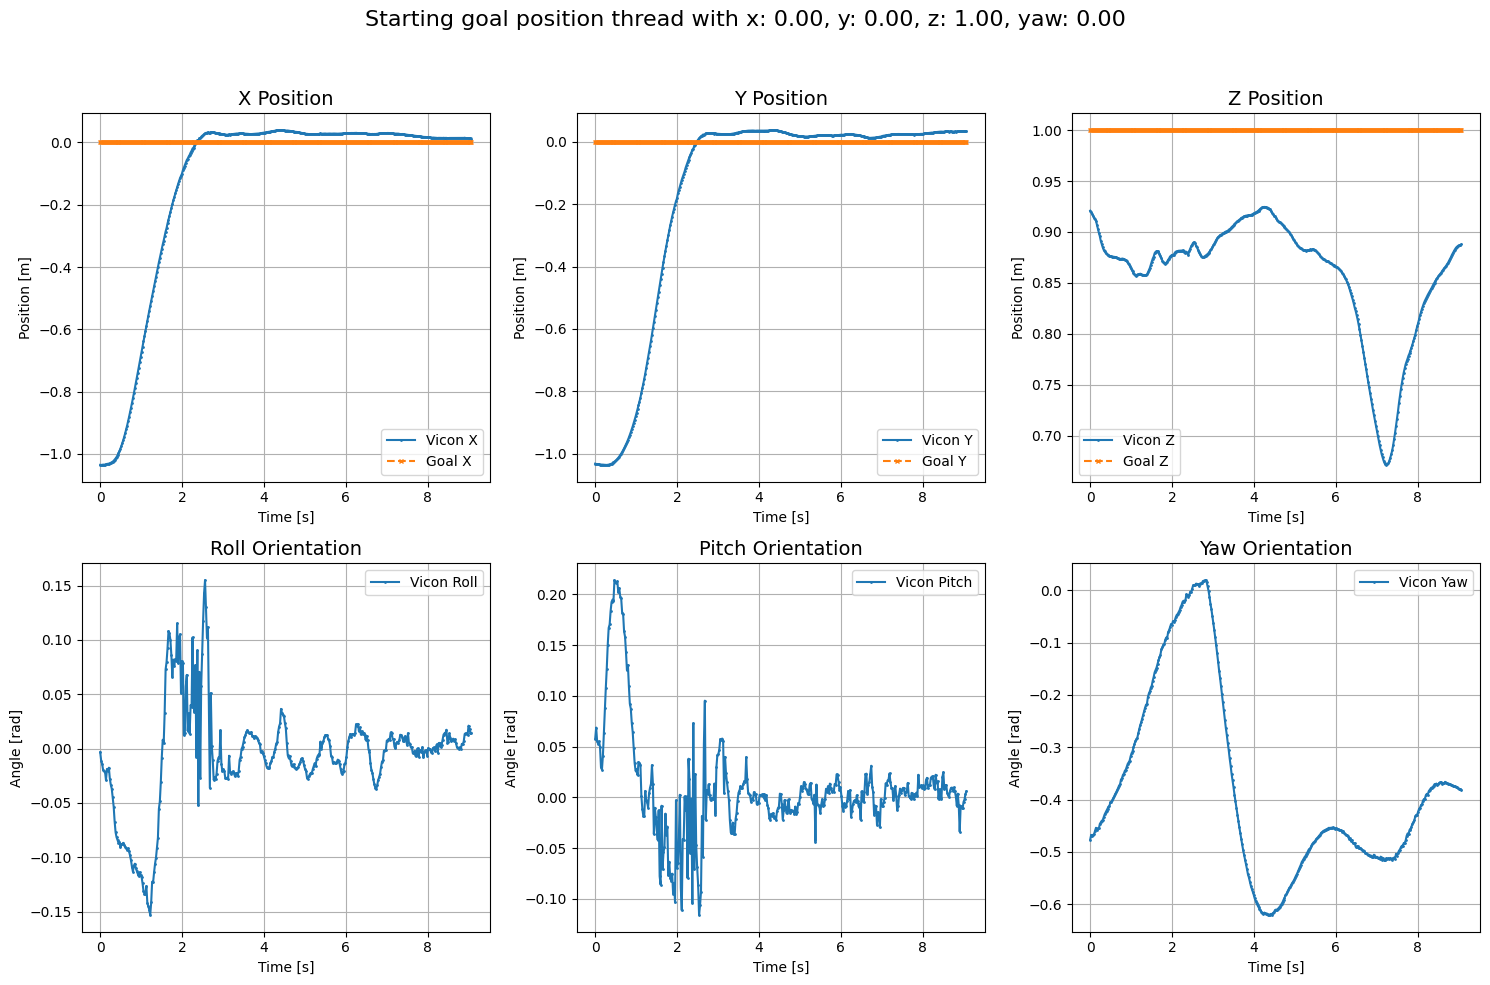

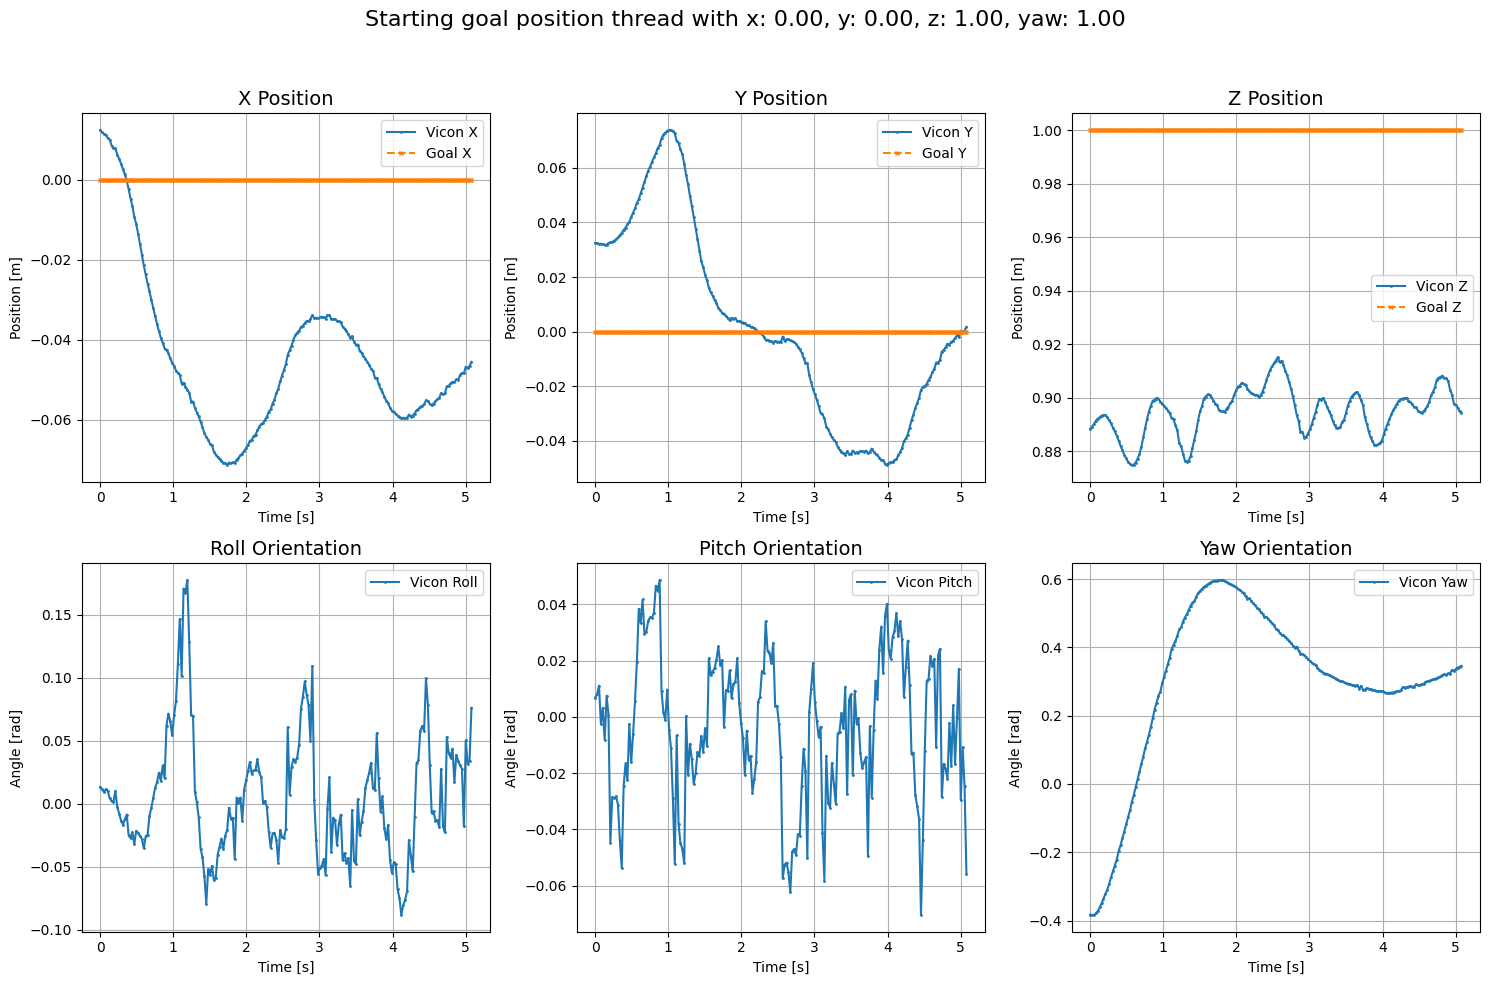

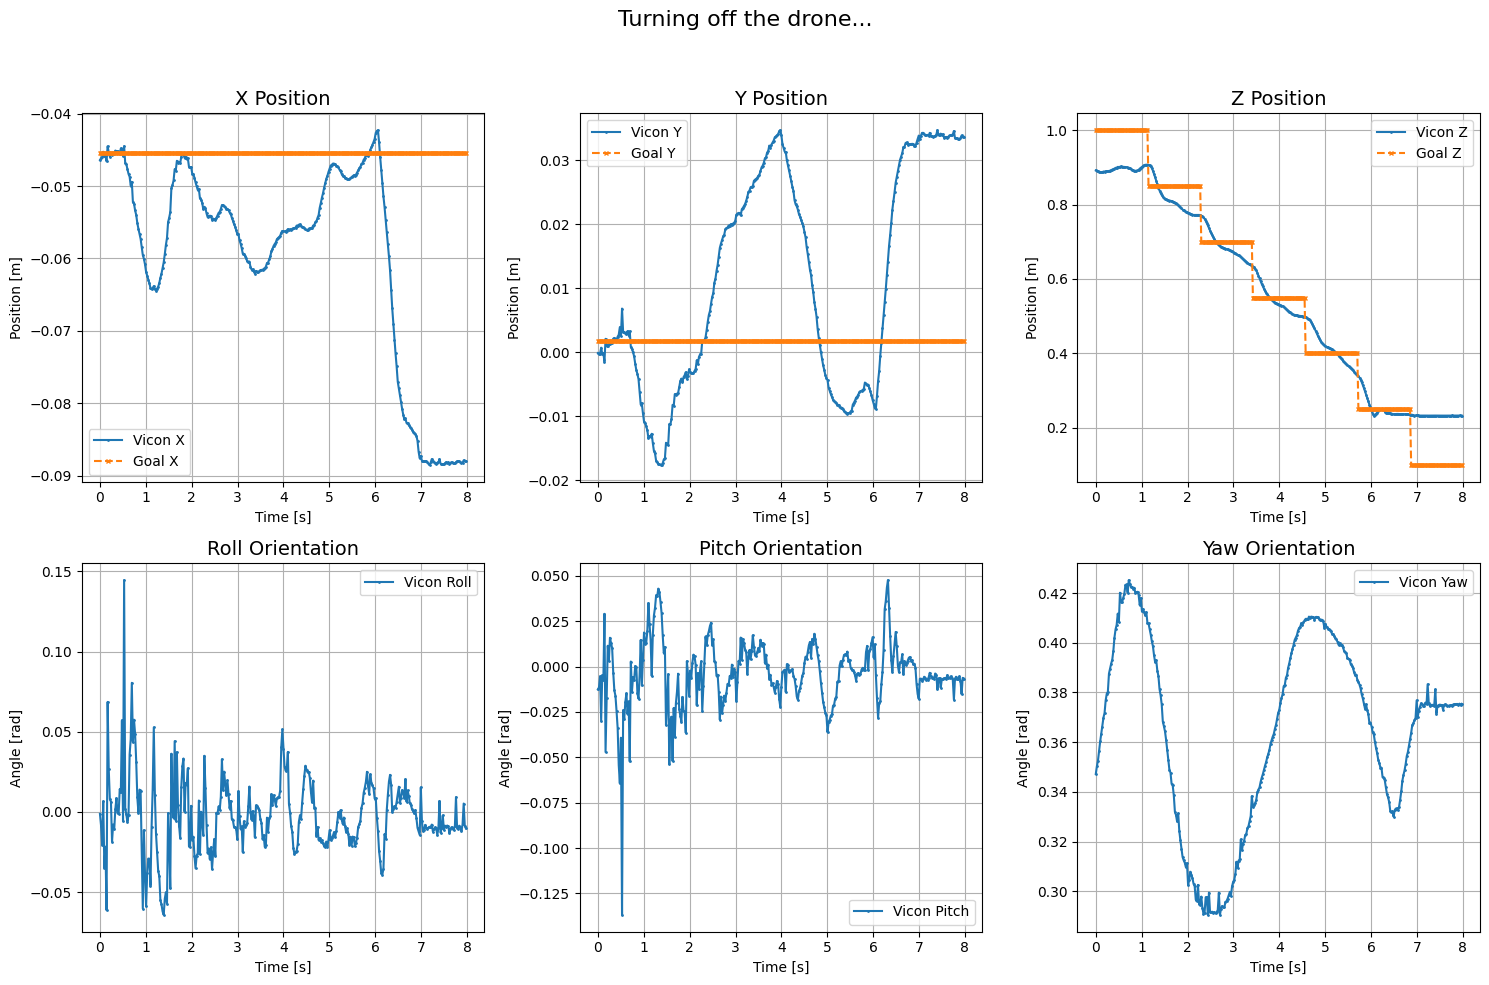

In [77]:
"""
Description of structure for rosout_msgs:

rosout_msgs[change_pos[i]][j][k][l]:

rosout_msgs : All data
- change_pos[i] = Index where the goal position is changed
- j = Package number 
- k = 0 (Vicon), 1 (Debug), 2 (Quatantion)
- l = Vicon : 0 (x), 1 (y), 2 (z), 3 (roll), 4 (pitch), 5 (yaw)
      Debug : 0 (goal x), 1 (goal y), 2 (goal z)
      Quatantion : 0 (q0), 1 (q1), 2 (q2), 3 (q3)
"""
linreg_plot(rosout_msgs[change_pos[-1]][40:260])

for data in change_pos:
    plot(rosout_msgs[data])
